# Real Time Location by Nearest Neighbour Methods 
## Case Study 

### Amit Patel
### Murali Parthasarathy
### Sanjay Jagalarmudi

The Growing commuication channels like wireless and bluetooth has open up the need to track personnel withing buildings. The GPS signals is severly restricted to locate personnel withing buidlings. This constraint has opened the doors indoor mapping with wireless and bluetooth. The bluetooth 5.0 protocol will be a huge boost in indoor location determination. Google and Apple moved into this space using the ibeacon technology. The ibeacon technology using Blue tooth light protocols which are implemented in signalling devices. With the blue tooth light protocol implementation the BLE devices can emit signals and last for over three years. 

The traditional appraoch is to use a rule based engine to determine the location based on a floor plan. The same can be acheived by machine learing by leveraging a K Nearest Neighbours (KNN) algorithm. 

The case study leverages a study to determine location of devices tracking a wireless signal . Wireless signal emitting devices are placed in four corners of the room. The tracking devices are placed in different locations and the reading from the emitting devices are recorded. This data is used as the training data. The real time is then used with the training data to determine the location of the device in the floor. 
 
Steps for the process are as follows

Import the data from the Wirelss tracking data web site
Cleanse the data and determine the data structure
Use the cleansed data as the training data
Get the actual readings from the web site 
Add weightage based on distance
Execute the KNN algorithm
And cross validate the KNN algorithm 



## Data Collection


The readings from the devices at different locations are uploaded by the University of M.. to the WAR web site.
There are two sets of data one to build the training data and the other data set to identify the location based on the realtime data. 

The dataset consists of information about the emitting device and the scan device. The data set also includes emitting devices not in scope of the study. As a first step we remove the emitting devices not in scope. Also remove data where there is no reading from the scan device. 

The selected data structure stacks the scan device against the emitting device. The scan device data elements are as follows
1) TimeStamp
2) RSSI 
3) id - Id of the Scan device
4) Mac - Id of the Emitting device 
5) Pos - (x,y) co-ordinate of the scan device
6) Degree - The angle the device is tilted 

The Steps below load both the data sets 


In [1]:
 URL <- "http://rdatasciencecases.org/Data/offline.final.trace.txt"
 download.file(url=URL,destfile = "offlineFinalTrace.txt")

In [59]:
 URL <- "http://rdatasciencecases.org/Data/online.final.trace.txt"
 download.file(url=URL,destfile = "onlineFinalTrace.txt")

In [15]:
options(digits = 3)
# Read in the data
txt = readLines("offlineFinalTrace.txt")

In [16]:
sum(substr(txt, 1, 1) == "#")
length(txt)
strsplit(txt[4], ";")[[1]] # Examine structure the first data line

[1] 5312

[1] 151392

[1] "t=1139643118358"                    "id=00:02:2D:21:0F:33"              
 [3] "pos=0.0,0.0,0.0"                    "degree=0.0"                        
 [5] "00:14:bf:b1:97:8a=-38,2437000000,3" "00:14:bf:b1:97:90=-56,2427000000,3"
 [7] "00:0f:a3:39:e1:c0=-53,2462000000,3" "00:14:bf:b1:97:8d=-65,2442000000,3"
 [9] "00:14:bf:b1:97:81=-65,2422000000,3" "00:14:bf:3b:c7:c6=-66,2432000000,3"
[11] "00:0f:a3:39:dd:cd=-75,2412000000,3" "00:0f:a3:39:e0:4b=-78,2462000000,3"
[13] "00:0f:a3:39:e2:10=-87,2437000000,3" "02:64:fb:68:52:e6=-88,2447000000,1"
[15] "02:00:42:55:31:00=-84,2457000000,1"

In [17]:
tokens = strsplit(txt[4], "[;=,]")[[1]] #split at a ; = or , character
tokens[1:10] # information about the handheld device
tokens[c(2, 4, 6:8, 10)] # extract the values of these variables
tokens[ - ( 1:10 ) ] # recorded signals within this observation
tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)

[1] "t"                 "1139643118358"     "id"               
 [4] "00:02:2D:21:0F:33" "pos"               "0.0"              
 [7] "0.0"               "0.0"               "degree"           
[10] "0.0"

[1] "1139643118358"     "00:02:2D:21:0F:33" "0.0"              
[4] "0.0"               "0.0"               "0.0"

[1] "00:14:bf:b1:97:8a" "-38"               "2437000000"       
 [4] "3"                 "00:14:bf:b1:97:90" "-56"              
 [7] "2427000000"        "3"                 "00:0f:a3:39:e1:c0"
[10] "-53"               "2462000000"        "3"                
[13] "00:14:bf:b1:97:8d" "-65"               "2442000000"       
[16] "3"                 "00:14:bf:b1:97:81" "-65"              
[19] "2422000000"        "3"                 "00:14:bf:3b:c7:c6"
[22] "-66"               "2432000000"        "3"                
[25] "00:0f:a3:39:dd:cd" "-75"               "2412000000"       
[28] "3"                 "00:0f:a3:39:e0:4b" "-78"              
[31] "2462000000"        "3"                 "00:0f:a3:39:e2:10"
[34] "-87"               "2437000000"        "3"                
[37] "02:64:fb:68:52:e6" "-88"               "2447000000"       
[40] "1"                 "02:00:42:55:31:00" "-84"              
[43] "2457000000"        "1"

In [18]:
# Build a matrix from the recorded signals
mat = cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
                   ncol = 6, byrow = TRUE), 
            tmp)

dim(mat) # confirm dimension of the matrix

[1] 11 10

In [19]:
mat

1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:3b:c7:c6,-66,2432000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:dd:cd,-75,2412000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e0:4b,-78,2462000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e2:10,-87,2437000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,02:64:fb:68:52:e6,-88,2447000000,1
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,02:00:42:55:31:00,-84,2457000000,1


In [20]:
processLine =
  function(x)
  {
    tokens = strsplit(x, "[;=,]")[[1]]
    tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
    cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
                 ncol = 6, byrow = TRUE), tmp)
  }

In [21]:
tmp = lapply(txt[4:20], processLine) # make sure it works on the first 16 lines
sapply(tmp, nrow) # Find the number of records per row

# Turn these individual matrices into a single data frame
offline = as.data.frame(do.call("rbind", tmp)) # faster than a for loop!
dim(offline)
# Here we go - reading in some data
lines = txt[ substr(txt, 1, 1) != "#" ]
tmp = lapply(lines, processLine)


[1] 11 10 10 11  9 10  9  9 10 11 11  9  9  9  8 10 14

[1] 170  10

Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”

In [22]:
processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
  return(NULL)
  
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
  byrow = TRUE), tmp)
}

In [23]:
options(error = recover, warn = 1) # reset options
# Create the new data set
tmp = lapply(lines, processLine)
offline = as.data.frame(do.call("rbind", tmp), 
stringsAsFactors = FALSE)
dim(offline)

[1] 1181628      10

In [24]:
names(offline) = c("time", "scanMac", "posX", "posY", "posZ", 
                   "orientation", "mac", "signal", 
                   "channel", "type")

numVars = c("time", "posX", "posY", "posZ", 
            "orientation", "signal")
offline[ numVars ] =  lapply(offline[ numVars ], as.numeric)

offline = offline[ offline$type == "3", ]
offline = offline[ , "type" != names(offline) ]
dim(offline)


[1] 978443      9

The data gathering was done at 8 angles. The data does not confirm it . There are multiple angles the diagrams below outline the different angles which are reported. We need to pin it to the 8 defined angles . 

time1       time2     scanMac        posX        posY        posZ 
   "POSIXt"   "POSIXct" "character"   "numeric"   "numeric"   "numeric" 
orientation         mac      signal     channel     rawTime 
  "numeric" "character"   "numeric" "character"   "numeric"

      time                          posX           posY           posZ  
 Min.   :2006-02-11 13:01:58   Min.   : 0.0   Min.   : 0.0   Min.   :0  
 1st Qu.:2006-02-11 18:51:27   1st Qu.: 2.0   1st Qu.: 3.0   1st Qu.:0  
 Median :2006-02-12 01:27:58   Median :12.0   Median : 6.0   Median :0  
 Mean   :2006-02-16 20:27:37   Mean   :13.5   Mean   : 5.9   Mean   :0  
 3rd Qu.:2006-02-19 20:22:40   3rd Qu.:23.0   3rd Qu.: 8.0   3rd Qu.:0  
 Max.   :2006-03-10 02:11:10   Max.   :33.0   Max.   :13.0   Max.   :0  
  orientation      signal     
 Min.   :  0   Min.   :-99.0  
 1st Qu.: 90   1st Qu.:-69.0  
 Median :180   Median :-60.0  
 Mean   :167   Mean   :-61.7  
 3rd Qu.:270   3rd Qu.:-53.0  
 Max.   :360   Max.   :-25.0  

                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

[1] 203

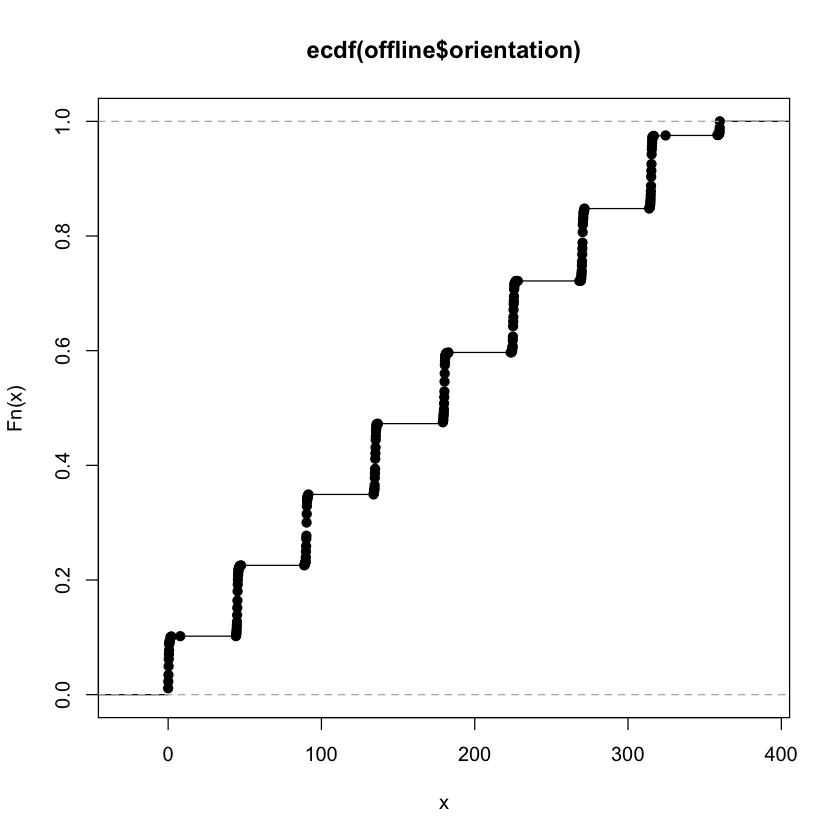

In [25]:
offline$rawTime = offline$time
offline$time = offline$time/1000
class(offline$time) = c("POSIXt", "POSIXct")

unlist(lapply(offline, class))

summary(offline[, numVars])

 summary(sapply(offline[ , c("mac", "channel", "scanMac")],
                as.factor))

offline = offline[ , !(names(offline) %in% c("scanMac", "posZ"))]

length(unique(offline$orientation))

plot(ecdf(offline$orientation))


In [27]:
pdf(file = "Geo_ECDFOrientation.pdf", width = 10, height = 7)
oldPar = par(mar = c(4, 4, 1, 1))
plot(ecdf(offline$orientation), pch = 19, cex = 0.3,
     xlim = c(-5, 365), axes = FALSE,
     xlab = "orientation", ylab = "Empirical CDF", main = "")
box()
axis(2)
axis(side = 1, at = seq(0, 360, by = 45))
par(oldPar)
dev.off()

pdf 
  2

The angle is rounded to the closest angle. The diagram shows the value after the rounding is done

In [28]:
pdf(file = "Geo_DensityOrientation.pdf", width = 10, height = 5)
oldPar = par(mar = c(4, 4, 1, 1))
plot(density(offline$orientation, bw = 2), 
 xlab = "orientation", main = "")
par(oldPar)
dev.off()

roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

offline$angle = roundOrientation(offline$orientation)

pdf(file = "Geo_BoxplotAngle.pdf", width = 10)
oldPar = par(mar = c(4, 4, 1, 1))

par(oldPar)
dev.off()

pdf 
  2

pdf 
  2

In [33]:
c(length(unique(offline$mac)), length(unique(offline$channel)))

table(offline$mac)

subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
offline = offline[ offline$mac %in% subMacs, ]

macChannel = with(offline, table(mac, channel))
apply(macChannel, 1, function(x) sum(x > 0))

offline = offline[ , "channel" != names(offline)]

locDF = with(offline, 
             by(offline, list(posX, posY), function(x) x))
length(locDF)

[1] 12  8


00:04:0e:5c:23:fc 00:0f:a3:39:dd:cd 00:0f:a3:39:e0:4b 00:0f:a3:39:e1:c0 
              418            145619             43508            145862 
00:0f:a3:39:e2:10 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
            19162            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 00:30:bd:f8:7f:c5 00:e0:63:82:8b:a9 
           121325            122315               301               103 

00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

[1] 476

In [35]:
sum(sapply(locDF, is.null))

locDF = locDF[ !sapply(locDF, is.null) ]

length(locDF)

locCounts = sapply(locDF, nrow)

locCounts = sapply(locDF, 
                   function(df) 
                     c(df[1, c("posX", "posY")], count = nrow(df)))

class(locCounts)

dim(locCounts)

locCounts[ , 1:8]

pdf(file = "Geo_XYByCount.pdf", width = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))

locCounts = t(locCounts)
plot(locCounts, type = "n", xlab = "", ylab = "")
text(locCounts, labels = locCounts[,3], cex = .8, srt = 45)

par(oldPar)
dev.off()

[1] 0

[1] 166

[1] "matrix"

[1]   3 166

posX,0,1,2,0,1,2,0,1
posY,0,0,0,1,1,1,2,2
count,5505,5505,5506,5524,5543,5558,5503,5564


pdf 
  2

In [36]:
readData = 
  function(filename = 'offlineFinalTrace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

In [37]:
sx = readData()
sx

,time,posX,posY,orientation,mac,signal,rawTime,angle
1,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:8a,-38,1.14e+12,0
2,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:90,-56,1.14e+12,0
3,2006-02-11 13:01:58,0,0,0,00:0f:a3:39:e1:c0,-53,1.14e+12,0
4,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:8d,-65,1.14e+12,0
5,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:81,-65,1.14e+12,0
6,2006-02-11 13:01:58,0,0,0,00:14:bf:3b:c7:c6,-66,1.14e+12,0
7,2006-02-11 13:01:58,0,0,0,00:0f:a3:39:dd:cd,-75,1.14e+12,0
12,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:8a,-38,1.14e+12,0
13,2006-02-11 13:01:58,0,0,0,00:0f:a3:39:e1:c0,-54,1.14e+12,0
14,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:90,-56,1.14e+12,0


In [38]:
offlineRedo = readData()

identical(offline, offlineRedo)

pdf(file = "Geo_BoxplotSignalByMacAngle.pdf", width = 7)
oldPar = par(mar = c(3.1, 3, 1, 1))



[1] TRUE

In [39]:
offline

,time,posX,posY,orientation,mac,signal,rawTime,angle
1,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:8a,-38,1.14e+12,0
2,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:90,-56,1.14e+12,0
3,2006-02-11 13:01:58,0,0,0,00:0f:a3:39:e1:c0,-53,1.14e+12,0
4,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:8d,-65,1.14e+12,0
5,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:81,-65,1.14e+12,0
6,2006-02-11 13:01:58,0,0,0,00:14:bf:3b:c7:c6,-66,1.14e+12,0
7,2006-02-11 13:01:58,0,0,0,00:0f:a3:39:dd:cd,-75,1.14e+12,0
12,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:8a,-38,1.14e+12,0
13,2006-02-11 13:01:58,0,0,0,00:0f:a3:39:e1:c0,-54,1.14e+12,0
14,2006-02-11 13:01:58,0,0,0,00:14:bf:b1:97:90,-56,1.14e+12,0


pdf 
  3

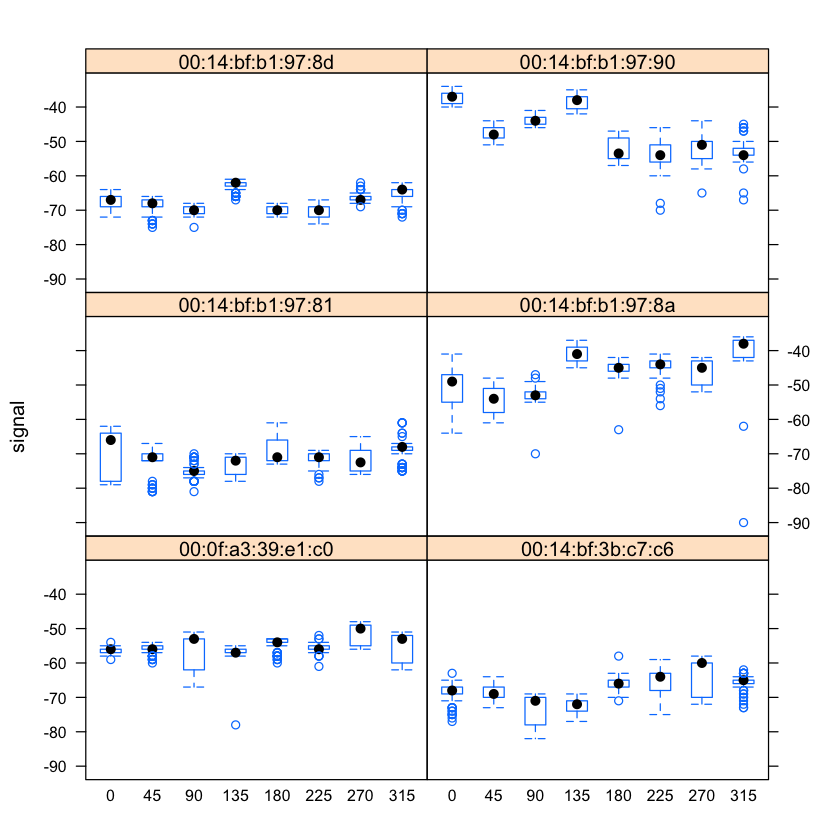

In [40]:
library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline, 
       subset = posX == 2 & posY == 12 
                & mac != "00:0f:a3:39:dd:cd", 
       layout = c(2,3))

par(oldPar)
dev.off()

The box plot shows the Signal strength distribution for each of the signal emitting device. The signal strength does not follow a normal distribution.

In [41]:
summary(offline$signal)

pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4 & 
                         mac != "00:0f:a3:39:dd:cd",
             bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()

#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -98.0   -67.0   -59.0   -59.9   -53.0   -25.0 

pdf 
  2

In [43]:
signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary) 

In [47]:
pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary, 
       subset = mac != "00:0f:a3:39:dd:cd",
       xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
dev.off()

pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar = par(mar = c(4.1, 4.1, 1, 1))

with(offlineSummary,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj = 
  with(offlineSummary,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
dev.off()

pdf 
  2

pdf 
  2

In [48]:
oneAPAngle = subset(offlineSummary, 
                    mac == subMacs[5] & angle == 0)




In [52]:
install.packages('fields', repos='http://cran.us.r-project.org')

also installing the dependencies ‘spam’, ‘maps’




The downloaded binary packages are in
	/var/folders/xf/bh2hb4kn2pdcczmncnsbh2q40000gn/T//RtmpWHAzh7/downloaded_packages


Loading required package: spam
Loading required package: grid
Spam version 1.4-0 (2016-08-29) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps


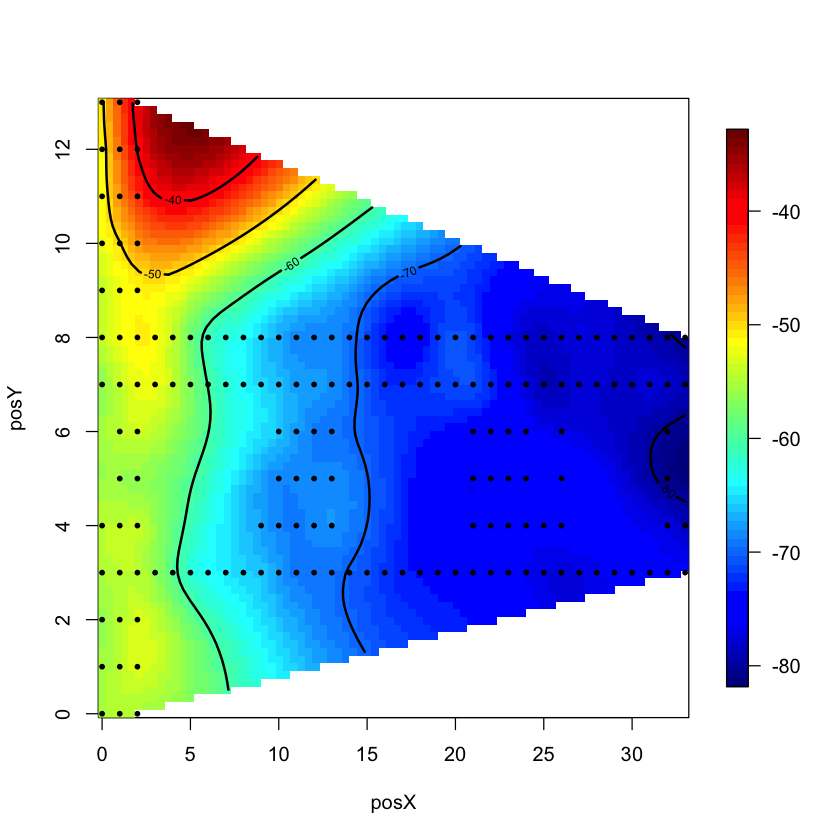

In [53]:
library(fields)
smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

Nearest Neighbour Method to determine Location

In [54]:
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL


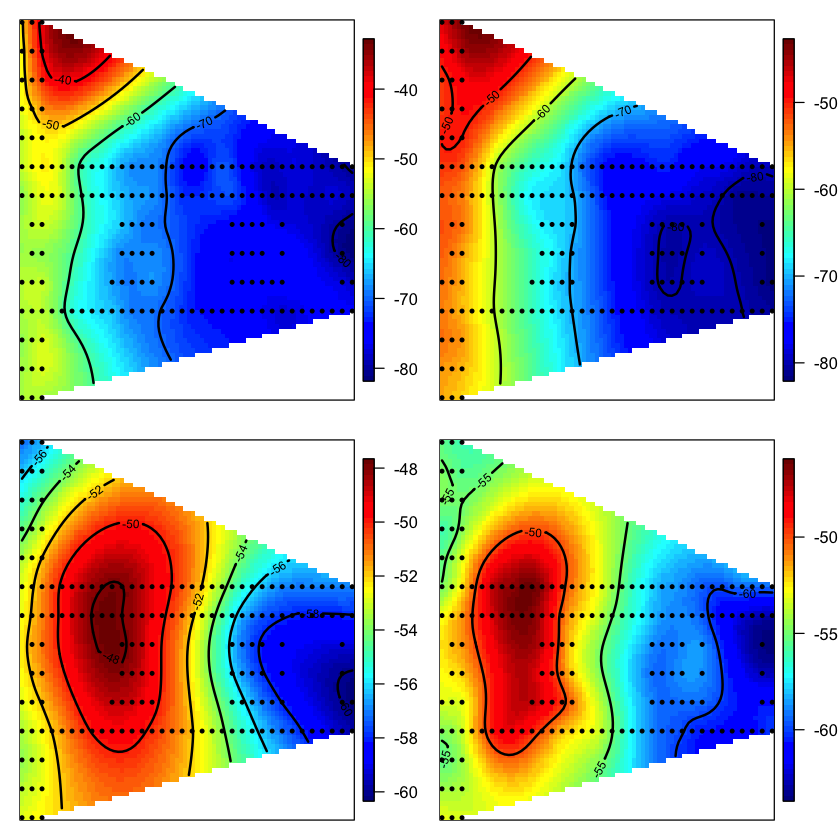

In [55]:
parCur = par(mfrow = c(2,2), mar = rep(1, 4))

mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ], 
       angle = rep(c(0, 135), 2),
       data = list(data = offlineSummary))
 
par(parCur)

offlineSummary = subset(offlineSummary, mac != subMacs[2])

AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -2 ], c("x", "y") ))


The diagram shows the signal strength from the access point. There are clearly areas where the signal strength is high and the angle at which the device faces the access point is a major factor in the signal strength

In [56]:
AP

,x,y
00:0f:a3:39:e1:c0,7.5,6.3
00:14:bf:b1:97:8a,2.5,-0.8
00:14:bf:3b:c7:c6,12.8,-2.8
00:14:bf:b1:97:90,1.0,14.0
00:14:bf:b1:97:8d,33.5,9.3
00:14:bf:b1:97:81,33.5,2.8


pdf 
  2

[1] 60

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 593   0   0   0   0
  0.15-9.42    0   0 606   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 573   0   0
  0.47-8.2   590   0   0   0   0   0   0   0
  0.78-10.94 586   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 583   0   0   0

[1] 60 11

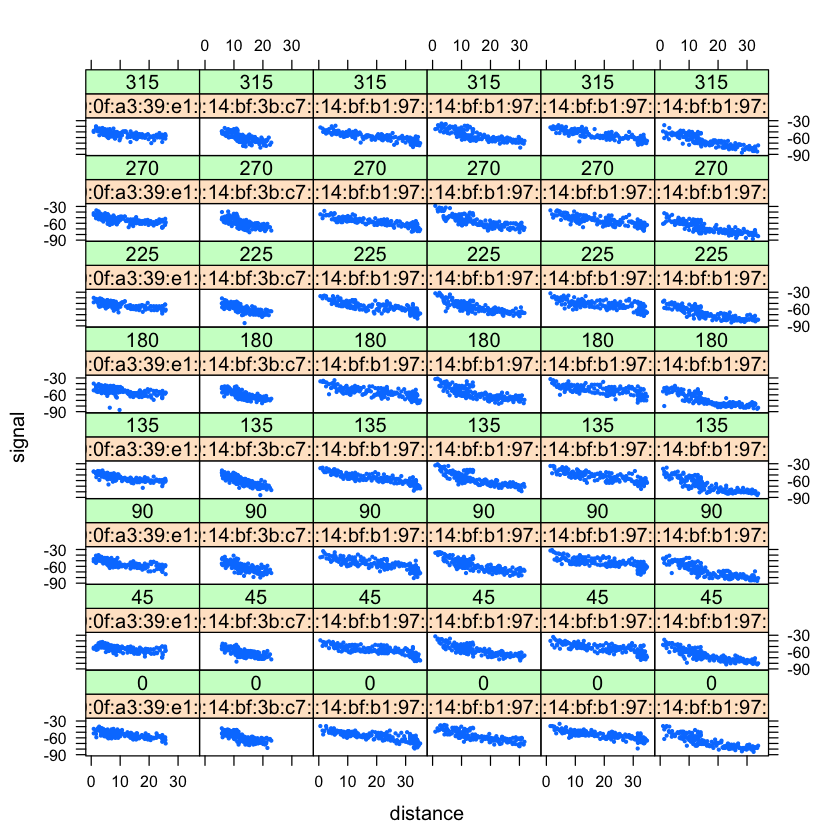

In [61]:
diffs = offlineSummary[ , c("posX", "posY")] - 
          AP[ offlineSummary$mac, ]

offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")

pdf(file="Geo_ScatterSignalDist.pdf", width = 7, height = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))
library(lattice)
xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")
par(oldPar)
dev.off()

macs = unique(offlineSummary$mac)
#online = readData("Data/online.final.trace.txt", subMacs = macs)
online = readData("onlineFinalTrace.txt",subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  

dim(onlineSummary)

The diagram shows the co relation between signal strength and distance 

In [62]:
names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:e1:c0"
 [7] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a"
[10] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [63]:
trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])

,posXY,posX,posY,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,-52.4,-66.1,-63.2,-35.6,-64.3,-55.3
0-1,0-1,0,1,-53.0,-65.4,-63.7,-39.4,-65.4,-59.2
0-10,0-10,0,10,-56.3,-65.7,-69.2,-44.7,-66.9,-50.5
0-11,0-11,0,11,-54.7,-67.2,-70.3,-48.3,-66.8,-54.9
0-12,0-12,0,12,-56.0,-70.5,-72.3,-45.2,-66.7,-50.5
0-13,0-13,0,13,-54.6,-71.2,-72.6,-43.3,-68.7,-54.5


[1] 166

Determining location by leveraging the Nearest Neighbour Methods 

In [64]:
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [65]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)

floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}


In [66]:
trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

pdf(file="GEO_FloorPlanK3Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

pdf(file="GEO_FloorPlanK1Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)


v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])


pdf 
  2

pdf 
  2

[1] 659 307

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
“data length [166] is not a sub-multiple or multiple of the number of rows [15]”

In [67]:
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

The accuracy of the method is increased by using weights which are inversely propotional to distance 

In [69]:
offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

pdf(file = "Geo_CVChoiceOfK.pdf", width = 10, height = 6)
oldPar = par(mar = c(4, 3, 1, 1))
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(1200, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))
par(oldPar)
dev.off()

estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 5)

calcError(estXYk5, actualXY)

predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = findNN(newSignal = as.numeric(newSignals[i, ]),
                           trainSS)
  }

  estXY = lapply(closeXY, function(x)
                            sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

[1] 64.3

pdf 
  2

[1] 276

Conclusion
The choice of K is a model decision. The choice of k should be be based on a minimum residual error. We notice that as the value of K increases more than 3 the residual error increases. 
The study does not include angle of the measuring device into account